In [2]:
import torch
import torch.nn as nn

In [3]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False 
}

In [4]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias=False)

    def forward(self,in_idx):
        batch_size,seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = torch.arange(seq_len,device=in_idx.device)
        pos_embeds = self.pos_emb(pos_embeds)
        x = tok_embeds + pos_embeds
        x = self.drop(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [5]:
class DummyTransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()

    def forward(self,x):
        return x

In [6]:
class DummyLayerNorm(nn.Module):
    def __init__(self,cfg):
        super().__init__()

    def forward(self,x):
        return x

In [7]:
import tiktoken

In [8]:
tokenizer = tiktoken.get_encoding("gpt2")

In [9]:
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch,dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [10]:
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(logits.shape)
print(logits)

torch.Size([2, 4, 50257])
tensor([[[ 0.0951, -0.6419, -0.2371,  ...,  0.6588,  1.2173,  0.9203],
         [-1.2524, -0.3743,  1.3181,  ..., -1.2595, -0.1629,  0.5030],
         [ 1.1644, -1.0527,  1.0691,  ..., -0.2865, -0.5562, -0.3865],
         [ 1.1907, -0.4656, -2.0759,  ..., -0.2542,  0.4579,  0.4072]],

        [[ 0.1233, -1.4938,  0.1963,  ...,  0.4612,  1.5600,  0.9473],
         [-0.3344, -0.5716,  1.3416,  ..., -0.2219,  0.5034,  0.7316],
         [ 0.5250, -0.3032,  0.2046,  ...,  1.0786, -1.2368, -0.9354],
         [ 0.0763,  0.1090, -1.8998,  ..., -1.1070,  1.2414,  0.0940]]],
       grad_fn=<UnsafeViewBackward0>)


In [11]:
class LayerNorm(nn.Module):
    
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True,unbiased=False)
        x = (x-mean) / torch.sqrt(var+self.eps)
        return x*self.scale + self.shift


In [12]:
class GELU(nn.Module):

    def __init__(self):
        super().__init__()


    def forward(self,x):
        return x*0.5*(1+torch.tanh(torch.sqrt(torch.tensor(2/torch.pi))*(x+0.044715*torch.pow(x,3))))

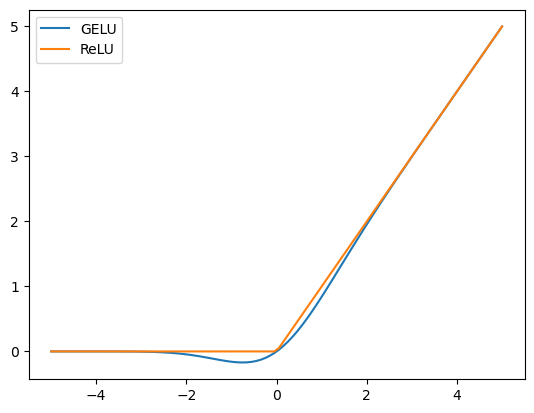

In [13]:
import matplotlib.pyplot as plt

gelu,relu = GELU(),nn.ReLU()
x = torch.linspace(-5,5,100)
y_gelu = gelu(x)
y_relu = relu(x)
plt.plot(x,y_gelu,label="GELU")
plt.plot(x,y_relu,label="ReLU")
plt.legend()
plt.show()

In [14]:
class FeedForward(nn.Module):
    
    def __init__(self,cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"],4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"],cfg["emb_dim"])
        )

    def forward(self,x):
        return self.layers(x)

In [15]:
class ExampleDNN(nn.Module):

    def __init__(self,layer_sizes,use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([nn.Linear(layer_sizes[i],layer_sizes[i+1]) for i in range(len(layer_sizes)-1)],GELU())

    def forward(self,x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [16]:
class MultiHeadAttention(nn.Module):

    def __init__(self,d_in,d_out,context_length,dropout, num_heads, qkv_bias= False):
        super().__init__()
        assert(d_out % num_heads == 0)
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in,d_out,bias = qkv_bias)
        self.W_key = nn.Linear(d_in,d_out,bias = qkv_bias)
        self.W_value = nn.Linear(d_in,d_out, bias = qkv_bias)
        self.out_proj = nn.Linear(d_out,d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length,context_length),diagonal=1)
        )
        
    def forward(self,x):
        b, num_tokens, d_in = x.shape
        
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b,num_tokens,self.num_heads, self.head_dim)
        values = values.view(b,num_tokens,self.num_heads, self.head_dim)
        queries = queries.view(b,num_tokens,self.num_heads, self.head_dim)
        
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        queries = queries.transpose(1,2)
        
        attn_scores = queries @ keys.transpose(2,3)
        
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]

        attn_scores.masked_fill_(mask_bool, - torch.inf)
        
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1] ** 0.5, dim = -1
        )
        
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values)

        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )

        context_vec = self.out_proj(context_vec)
        return context_vec

In [17]:
class TransformerBlock(nn.Module):

    def __init__(self,cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out= cfg["emb_dim"],
            context_length= cfg["context_length"],
            dropout= cfg["drop_rate"],
            num_heads= cfg["n_heads"],
            qkv_bias= cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop = nn.Dropout(cfg["drop_rate"])

    def forward(self,x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop(x)
        x = x + shortcut
        return x

In [28]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias=False)

    def forward(self,in_idx):
        # print(in_idx,in_idx.shape)
        batch_size,seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = torch.arange(seq_len,device=in_idx.device)
        # print(pos_embeds,pos_embeds.shape)
        pos_embeds = self.pos_emb(pos_embeds)
        # print(pos_embeds,pos_embeds.shape)
        x = tok_embeds + pos_embeds
        x = self.drop(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [29]:
model = GPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(logits.shape)
print(logits)

torch.Size([2, 4, 50257])
tensor([[[ 0.0604, -1.7405,  0.9173,  ...,  0.0067, -0.0851, -0.7796],
         [ 0.1375, -0.1715, -0.1559,  ...,  0.1143, -0.0124,  0.0289],
         [-0.8653,  0.3548, -0.8373,  ..., -0.0120, -0.4198,  0.8526],
         [ 0.2293,  0.0348, -0.8283,  ...,  0.2278, -0.0636, -0.1509]],

        [[ 0.2224, -1.7024,  0.5528,  ..., -0.1152, -0.5607, -0.6428],
         [ 0.8601, -0.5871,  0.0904,  ...,  0.2618, -0.2855, -0.2765],
         [ 0.2124, -0.6696, -1.1826,  ..., -0.0748,  0.6328,  0.5094],
         [ 0.4664,  0.1795, -0.5700,  ...,  0.9847, -0.4994,  0.8767]]],
       grad_fn=<UnsafeViewBackward0>)


In [30]:
def generate_text_simple(model,idx,max_new_tokens,context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.inference_mode():
            logits = model(idx_cond)
        logits = logits[:,-1,:]
        prob = torch.softmax(logits,dim=-1)
        idx_next = torch.argmax(prob,dim=-1,keepdim=True)
        idx = torch.cat([idx,idx_next],dim=-1)
    return idx
